In [ ]:
#Part a

from numba import cuda
import numpy as np
import sys

@cuda.jit
def grayscale_to_binary(img, threshold, binary_img):
    x, y = cuda.grid(2)
    if x < img.shape[0] and y < img.shape[1]:
        intensity = img[x, y]
        binary_img[x, y] = 1 if intensity >= threshold else 0

def main():
    grayscale_img = np.array([[100, 150, 200], [50, 125, 250], [90, 180, 220]], dtype=np.uint8)
    rows, cols = grayscale_img.shape
    threshold = 127

    binary_img = np.zeros((rows, cols), dtype=np.uint8)

    d_img = cuda.to_device(grayscale_img)
    d_binary_img = cuda.to_device(binary_img)

    threads_per_block = (16, 16)
    blocks_per_grid_x = (rows + threads_per_block[0] - 1) // threads_per_block[0]
    blocks_per_grid_y = (cols + threads_per_block[1] - 1) // threads_per_block[1]
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    grayscale_to_binary[blocks_per_grid, threads_per_block](d_img, threshold, d_binary_img)

    binary_img = d_binary_img.copy_to_host()

    print("Original grayscale image:\n", grayscale_img)
    print(f"Binary image with threshold {threshold}:\n", binary_img)

if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Original grayscale image:
 [[100 150 200]
 [ 50 125 250]
 [ 90 180 220]]
Binary image with threshold 127:
 [[0 1 1]
 [0 0 1]
 [0 1 1]]


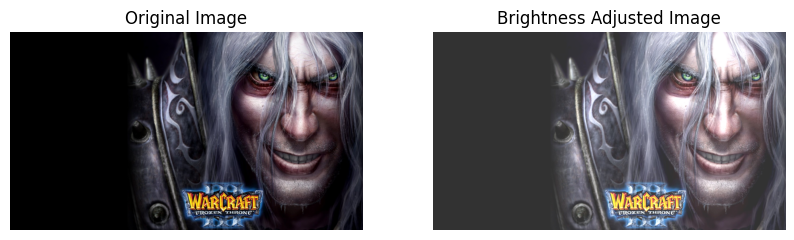

In [ ]:
#Part B
from numba import cuda
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

@cuda.jit
def adjust_brightness_color(pixels, adjustment):
    x, y = cuda.grid(2)
    if x < pixels.shape[0] and y < pixels.shape[1]:
        for c in range(3):
            pixels[x, y, c] = min(255, max(0, pixels[x, y, c] + adjustment))

input_image = Image.open("592650.jpg")
pixels = np.array(input_image, dtype=np.uint8)

adjustment_value = 50

d_pixels = cuda.to_device(pixels)

threads_per_block = (16, 16)
blocks_per_grid_x = (pixels.shape[0] + threads_per_block[0] - 1) // threads_per_block[0]
blocks_per_grid_y = (pixels.shape[1] + threads_per_block[1] - 1) // threads_per_block[1]
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

adjust_brightness_color[blocks_per_grid, threads_per_block](d_pixels, adjustment_value)

adjusted_pixels = d_pixels.copy_to_host()

output_image = Image.fromarray(adjusted_pixels)
output_image.save("output_image.jpg")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(input_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Brightness Adjusted Image")
plt.imshow(output_image)
plt.axis("off")

plt.show()

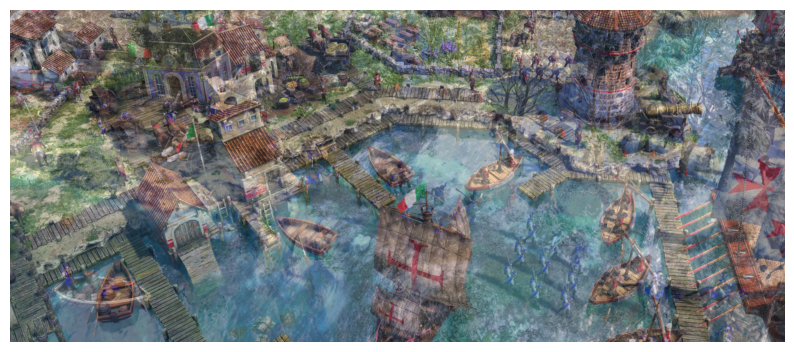

In [12]:
import cupy as cp
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def load_image_to_gpu(image_path):
    img = Image.open(image_path).convert('RGB')
    img_np = np.array(img)
    img_gpu = cp.asarray(img_np)
    return img_gpu

def blend_images_gpu(image1_path, image2_path, c):
    img1_gpu = load_image_to_gpu(image1_path)
    img2_gpu = load_image_to_gpu(image2_path)

    if img1_gpu.shape != img2_gpu.shape:
        raise ValueError("Images must have the same dimensions")

    blended_gpu = c * img1_gpu + (1 - c) * img2_gpu
    return blended_gpu

image1_path = 'mediterranean-splash1-4k-scaled.png'
image2_path = 'mediterranean-splash3-4k-scaled.png'
c = 0.6

blended_image_gpu = blend_images_gpu(image1_path, image2_path, c)
blended_image_np = cp.asnumpy(blended_image_gpu)
result_image = Image.fromarray(blended_image_np.astype(np.uint8))

plt.figure(figsize=(10, 8))
plt.imshow(result_image)
plt.axis('off')
plt.show()